Welcome! In this notebook we aim to estimate the compute and memory requirements needed to train a theoretical model architecture using LightGPT. We'll start by first defining the parameters of the architecture.

In [13]:
# Model
vocabulary_size = 50257
embedding_dimensions = 1024
num_attention_heads = 16
num_hidden_layers = 24
feed_forward_ratio = 4

# Training set
tokens_per_sample = 1024
samples_per_epoch = 4096

Next, we'll estimate the total number of trainable parameters in the network.

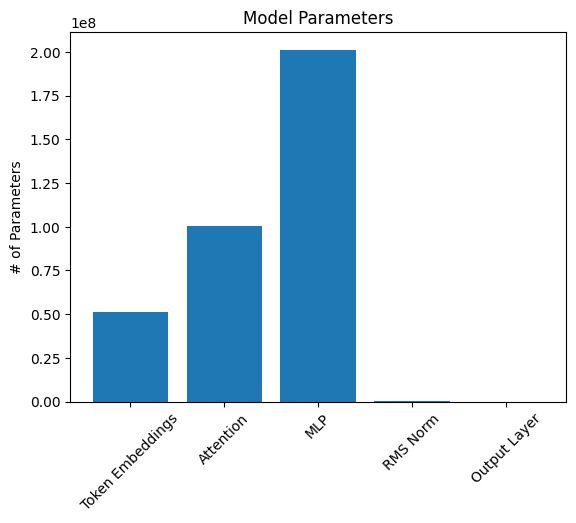

Token Embeddings               51,463,168      14.56%
Attention                     100,663,296      28.48%
MLP                           201,326,592      56.95%
RMS Norm                           50,176       0.01%
Output Layer                            0       0.00%
Total parameters: 353,503,232


In [14]:
import matplotlib.pyplot as plt

parameter_counts = {
    "Token Embeddings": vocabulary_size * embedding_dimensions,
    "Attention": (
        embedding_dimensions**2 + embedding_dimensions * 3 * embedding_dimensions
    )
    * num_hidden_layers,
    "MLP": embedding_dimensions
    * feed_forward_ratio
    * embedding_dimensions
    * 2
    * num_hidden_layers,
    "RMS Norm": embedding_dimensions * num_hidden_layers * 2 + embedding_dimensions,
    "Output Layer": 0,  # Tied to token embeddings
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")


print(f"Total parameters: {total_parameter_count:,}")

To get an idea of the "shape" of our neural network we'll look at the ratio of embedding dimensions to number of layers. Generally, an aspect ratio between 50 and 100 is considered optimal according to certain scaling laws (Kaplan, 2020).

In [15]:
aspect_ratio = embedding_dimensions / num_hidden_layers

print(f"Network has an aspect ratio of {aspect_ratio:.2f}")

Network has an aspect ratio of 42.67


We can do the same analysis for the ratio of embedding dimensions to the number of attention heads. In this case, a ratio of between 20 and 80 is considered optimal according to the same paper.

In [16]:
heads_ratio = embedding_dimensions / num_attention_heads

print(f"Heads ratio is {heads_ratio:.2f}")

Heads ratio is 64.00


Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training such as activations, gradients, optimizer state, and temporary buffers. Actual memory consumption will likely be much higher.

In [17]:
bytes_per_parameter = 32 // 8  # Assuming 32-bit floating point

total_bytes = total_parameter_count * bytes_per_parameter

total_gigabytes = total_bytes / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}G")

Total gigabytes: 1.41G


We can estimate the optimal number of training tokens using the Chinchilla scaling law given the number of parameters.

In [18]:
num_training_tokens = 20 * total_parameter_count

num_epochs_required = round(
    num_training_tokens / (samples_per_epoch * tokens_per_sample)
)

print(f"Optimal training tokens: {num_training_tokens:,}")

print(f"Epochs required: {num_epochs_required:,}", end="\n\n")

Optimal training tokens: 7,070,064,640
Epochs required: 1,686



Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the network on a single sample.

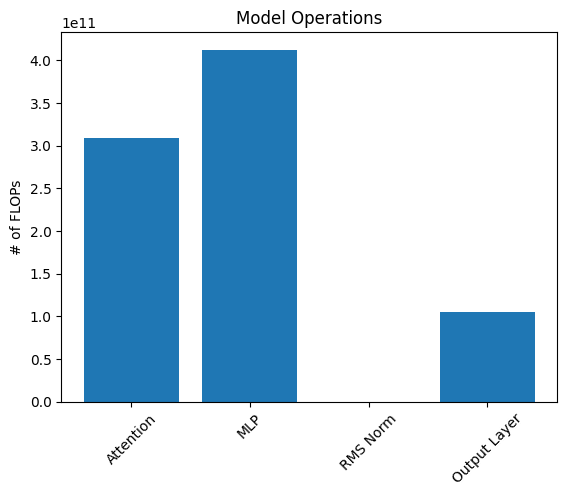

Attention                 309,237,645,312      37.39%
MLP                       412,317,351,936      49.86%
RMS Norm                          179,200       0.00%
Output Layer              105,396,568,064      12.75%


Total forward FLOPs: 826,951,744,512


In [19]:
ops_per_matmul = 2  # Multiply + accumulate (MAC)
ops_per_activation = 5  # Assuming SiLU
ops_per_rms_norm = 7  # y = (x / sqrt(rms[x] + epsilon)) * gamma

head_dimensions = embedding_dimensions // num_attention_heads

# K, Q, V projections
attention = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * 3 * embedding_dimensions)
)

# Attention logits
attention += (
    ops_per_matmul * tokens_per_sample * tokens_per_sample * embedding_dimensions
)

# Reductions
attention += (
    ops_per_matmul
    * num_attention_heads
    * (tokens_per_sample * tokens_per_sample * head_dimensions)
)

# Output projection
attention += ops_per_matmul * tokens_per_sample * embedding_dimensions**2

attention *= num_hidden_layers

# Linear transformations
mlp = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * (4 * embedding_dimensions))
)
mlp += (
    ops_per_matmul
    * tokens_per_sample
    * ((4 * embedding_dimensions) * embedding_dimensions)
)

# Non-linear activations
mlp += ops_per_activation * (4 * embedding_dimensions)

mlp *= num_hidden_layers

rms_norm = ops_per_rms_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = (
    ops_per_matmul * tokens_per_sample * embedding_dimensions * vocabulary_size
)

flops = {
    "Attention": attention,
    "MLP": mlp,
    "RMS Norm": rms_norm,
    "Output Layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2X the forward pass.

In [20]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 1,653,903,489,024


We'll do the same for the total FLOPs per roundtrip.

In [21]:
total_roundtrip_flops = total_forward_flops + total_backward_flops

print(f"Total roundtrip FLOPs: {total_roundtrip_flops:,}")

Total roundtrip FLOPs: 2,480,855,233,536


Now, let's estimate the number of FLOPs using the method in the PaLM paper by Chowdhery, et al. Then, we'll compare the PaLM estimation with our own as a sanity check.

In [22]:
palm_flops_per_token = (
    6 * total_parameter_count
    + 12 * num_hidden_layers * num_attention_heads * head_dimensions * tokens_per_sample
)

total_palm_flops = palm_flops_per_token * tokens_per_sample

print(f"Total PaLM FLOPs: {total_palm_flops:,}")

Total PaLM FLOPs: 2,481,161,502,720


The two estimates are pretty close so let's proceed.

Finally, let's estimate how long it would take to train over the optimal number of tokens given some common Nvidia Ampere generation GPU hardware configurations. Note that these results shown here are a theoretical scenario and do not factor in additional overhead such as activation checkpointing or network latency.

In [23]:
from dataclasses import dataclass


@dataclass
class Device:
    name: str
    advertised_flops: float
    mfu: float

    @property
    def actual_flops(self) -> float:
        return self.mfu * self.advertised_flops


devices = [
    Device("RTX A2000", 63.9e12, 0.17),
    Device("RTX A4000", 153.4e12, 0.19),
    Device("RTX 3090", 285.5e12, 0.23),
    Device("A100 SXM", 624.0e12, 0.37),
    Device("HGX A100", 4992e12, 0.30),
]

for device in devices:
    seconds_per_epoch = samples_per_epoch * total_roundtrip_flops / device.actual_flops

    days_required = num_epochs_required * seconds_per_epoch / 60 / 60 / 24

    print(
        f"{device.name}: {seconds_per_epoch:.2f} seconds/epoch, {days_required:,.2f} days required"
    )

RTX A2000: 935.43 seconds/epoch, 18.25 days required
RTX A4000: 348.64 seconds/epoch, 6.80 days required
RTX 3090: 154.75 seconds/epoch, 3.02 days required
A100 SXM: 44.01 seconds/epoch, 0.86 days required
HGX A100: 6.79 seconds/epoch, 0.13 days required
